<h1 align="center">Registration Settings: Choices, Choices, Choices</h1>

The performance of most registration algorithms is dependent on a large number of parameter settings. For optimal performance you will need to customize your settings, turning all the knobs to their "optimal" position:<br>
<img src="knobs.jpg" style="width:700px"/>
<font size="1"> [This image was originally posted to Flickr and downloaded from wikimedia commons https://commons.wikimedia.org/wiki/File:TASCAM_M-520_knobs.jpg]</font>

This notebook illustrates the use of reference data (a.k.a "gold" standard) to empirically tune a registration framework for specific usage. This is dependent on the characteristics of your images (anatomy, modality, image's physical spacing...) and on the clinical needs.

Also keep in mind that the definition of optimal settings does not necessarily correspond to those that provide the most accurate results. 

The optimal settings are task specific and should provide:
<ul>
<li>Sufficient accuracy in the Region Of Interest (ROI).</li>
<li>Complete the computation in the allotted time.</li>
</ul>

We will be using the training data from the  Retrospective Image Registration Evaluation (<a href="http://www.insight-journal.org/rire/">RIRE</a>) project.

In [1]:
import SimpleITK as sitk

# Utility method that either downloads data from the network or
# if already downloaded returns the file name for reading from disk (cached data).
%run update_path_to_download_script
from downloaddata import fetch_data as fdata

# Always write output to a separate directory, we don't want to pollute the source directory. 
OUTPUT_DIR = 'Output'

%matplotlib inline
import registration_callbacks as rc
import registration_utilities as ru


### Read the RIRE data and generate a larger point set as a reference

Fetching training_001_ct.mha
Fetching training_001_mr_T1.mha
Fetching ct_T1.standard
Downloaded 1064 of 1064 bytes (100.00%)
Reference data errors (FRE) in millimeters, mean(std): 0.00(0.00), max: 0.00


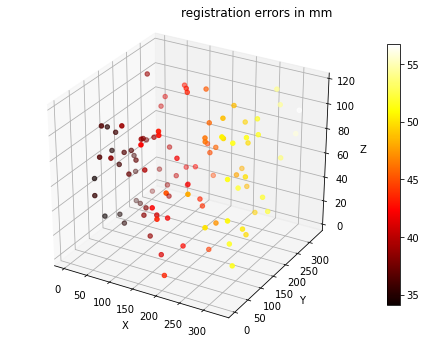

Before registration, errors (TRE) in millimeters, mean(std): 43.55(5.99), max: 56.72


In [2]:
fixed_image =  sitk.ReadImage(fdata("training_001_ct.mha"), sitk.sitkFloat32)
moving_image = sitk.ReadImage(fdata("training_001_mr_T1.mha"), sitk.sitkFloat32) 
fixed_fiducial_points, moving_fiducial_points = ru.load_RIRE_ground_truth(fdata("ct_T1.standard"))

# Estimate the reference_transform defined by the RIRE fiducials and check that the FRE makes sense (low) 
R, t = ru.absolute_orientation_m(fixed_fiducial_points, moving_fiducial_points)
reference_transform = sitk.Euler3DTransform()
reference_transform.SetMatrix(R.flatten())
reference_transform.SetTranslation(t)
reference_errors_mean, reference_errors_std, _, reference_errors_max,_ = ru.registration_errors(reference_transform, fixed_fiducial_points, moving_fiducial_points)
print('Reference data errors (FRE) in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(reference_errors_mean, reference_errors_std, reference_errors_max))

# Generate a reference dataset from the reference transformation 
# (corresponding points in the fixed and moving images).
fixed_points = ru.generate_random_pointset(image=fixed_image, num_points=100)
moving_points = [reference_transform.TransformPoint(p) for p in fixed_points]    

# Compute the TRE prior to registration.
pre_errors_mean, pre_errors_std, pre_errors_min, pre_errors_max, _ = ru.registration_errors(sitk.Euler3DTransform(), fixed_points, moving_points, display_errors = True)
print('Before registration, errors (TRE) in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(pre_errors_mean, pre_errors_std, pre_errors_max))

### Initial Alignment

We use the CenteredTransformInitializer. Should we use the GEOMETRY based version or the MOMENTS based one?

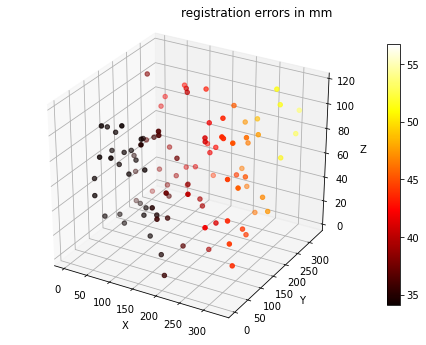

After initialization, errors (TRE) in millimeters, mean(std): 39.44(5.87), max: 53.77


In [3]:
initial_transform = sitk.CenteredTransformInitializer(sitk.Cast(fixed_image,moving_image.GetPixelID()), 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

initial_errors_mean, initial_errors_std, initial_errors_min, initial_errors_max, _ = ru.registration_errors(initial_transform, fixed_points, moving_points, min_err=pre_errors_min, max_err=pre_errors_max, display_errors=True)
print('After initialization, errors (TRE) in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(initial_errors_mean, initial_errors_std, initial_errors_max))

## Registration

Possible choices for simple rigid multi-modality registration framework (<b>300</b> component combinations, in addition to parameter settings for each of the components):
<ul>
<li>Similarity metric, 2 options (Mattes MI, JointHistogram MI):
<ul>
  <li>Number of histogram bins.</li>
  <li>Sampling strategy, 3 options (NONE, REGULAR, RANDOM)</li>
  <li>Sampling percentage.</li>
</ul>
</li>
<li>Interpolator, 10 options (sitkNearestNeighbor, sitkLinear, sitkGaussian, sitkBSpline,...)</li>
<li>Optimizer, 5 options (GradientDescent, GradientDescentLineSearch, RegularStepGradientDescent...): 
<ul>
  <li>Number of iterations.</li>
  <li>learning rate (step size along parameter space traversal direction).</li>
</ul>
</li>
</ul>

In this example we will plot the similarity metric's value and more importantly the TREs for our reference data. A good choice for the former should be reflected by the later. That is, the TREs should go down as the similarity measure value goes down (not necessarily at the same rates).

Finally, we are also interested in timing our registration. IPython allows us to do this with minimal effort using the <a href="http://ipython.org/ipython-doc/stable/interactive/magics.html?highlight=timeit#magic-timeit">timeit</a> cell magic (IPython has a set of predefined functions that use a command line syntax, and are referred to as magic functions). 

In [4]:
#%%timeit -r1 -n1
# to time this cell uncomment the line above
#the arguments to the timeit magic specify that this cell should only be run once. running it multiple 
#times to get performance statistics is also possible, but takes time. if you want to analyze the accuracy 
#results from multiple runs you will have to modify the code to save them instead of just printing them out.

registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)
registration_method.SetInterpolator(sitk.sitkNearestNeighbor) #2. Replace with sitkLinear
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100) #1. Increase to 1000
registration_method.SetOptimizerScalesFromPhysicalShift() 
     
# Don't optimize in-place, we would like to run this cell multiple times
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Add callbacks which will display the similarity measure value and the reference data during the registration process
registration_method.AddCommand(sitk.sitkStartEvent, rc.metric_and_reference_start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, rc.metric_and_reference_end_plot)
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rc.metric_and_reference_plot_values(registration_method, fixed_points, moving_points))

final_transform_single_scale = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                           sitk.Cast(moving_image, sitk.sitkFloat32))

print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
final_errors_mean, final_errors_std, _, final_errors_max,_ = ru.registration_errors(final_transform_single_scale, fixed_points, moving_points, min_err=initial_errors_min, max_err=initial_errors_max, display_errors=True)
print('After registration, errors in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(final_errors_mean, final_errors_std, final_errors_max))

AttributeError: module 'SimpleITK' has no attribute 'CompositeTransform'

RuntimeError: Exception thrown in SimpleITK ImageRegistrationMethod_Execute: /Users/changhua/SimpleElastix/Wrapping/Python/sitkPyCommand.cxx:135:
sitk::ERROR: There was an error executing the Python Callable.

In some cases visual comparison of the registration errors using the same scale is not informative, as seen above [all points are gray/black]. We therefor set the color scale to the min-max error range found in the current data and not the range from the previous stage.

In [ ]:
final_errors_mean, final_errors_std, _, final_errors_max,_ = ru.registration_errors(final_transform_single_scale, fixed_points, moving_points, display_errors=True)

### Now using the built in multi-resolution framework

Perform registration using the same settings as above, but take advantage of the multi-resolution framework which provides a significant speedup with minimal effort (3 lines of code).

It should be noted that when using this framework the similarity metric value will not necessarily decrease between resolutions, we are only ensured that it decreases per resolution. This is not an issue, as we are actually observing the values of a different function at each resolution. 

The example below shows that registration is improving even though the similarity value increases when changing resolution levels.

In [5]:
#%%timeit -r1 -n1
#the arguments to the timeit magic specify that this cell should only be run once. running it multiple 
#times to get performance statistics is also possible, but takes time. if you want to analyze the accuracy 
#results from multiple runs you will have to modify the code to save them instead of just printing them out.

registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.1)
registration_method.SetInterpolator(sitk.sitkLinear) #2. Replace with sitkLinear
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100) 
registration_method.SetOptimizerScalesFromPhysicalShift() 
     
# Don't optimize in-place, we would like to run this cell multiple times
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Add callbacks which will display the similarity measure value and the reference data during the registration process
registration_method.AddCommand(sitk.sitkStartEvent, rc.metric_and_reference_start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, rc.metric_and_reference_end_plot)
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rc.metric_and_reference_plot_values(registration_method, fixed_points, moving_points))

registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                              sitk.Cast(moving_image, sitk.sitkFloat32))

print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
final_errors_mean, final_errors_std, _, final_errors_max,_ = ru.registration_errors(final_transform, fixed_points, moving_points, True)

print('After registration, errors in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(final_errors_mean, final_errors_std, final_errors_max))

AttributeError: module 'SimpleITK' has no attribute 'CompositeTransform'

RuntimeError: Exception thrown in SimpleITK ImageRegistrationMethod_Execute: /Users/changhua/SimpleElastix/Wrapping/Python/sitkPyCommand.cxx:135:
sitk::ERROR: There was an error executing the Python Callable.

### Sufficient accuracy <u>inside</u> the ROI 

Up to this point our accuracy evaluation has ignored the content of the image and is likely overly conservative. We have been looking at the registration errors inside the volume, but not necessarily in the smaller ROI.

To see the difference you will have to <b>comment out the timeit magic in the code above</b>, run it again, and then run the following cell.

In [6]:
# Threshold the original fixed, CT, image at 0HU (water), resulting in a binary labeled [0,1] image.
roi = fixed_image> 0

# Our ROI consists of all voxels with a value of 1, now get the bounding box surrounding the head.
label_shape_analysis = sitk.LabelShapeStatisticsImageFilter()
label_shape_analysis.SetBackgroundValue(0)
label_shape_analysis.Execute(roi)
bounding_box = label_shape_analysis.GetBoundingBox(1)

# Bounding box in physical space.
sub_image_min = fixed_image.TransformIndexToPhysicalPoint((bounding_box[0],bounding_box[1], bounding_box[2]))
sub_image_max = fixed_image.TransformIndexToPhysicalPoint((bounding_box[0]+bounding_box[3]-1,
                                                           bounding_box[1]+bounding_box[4]-1, 
                                                           bounding_box[2]+bounding_box[5]-1))
# Only look at the points inside our bounding box.
sub_fixed_points = []
sub_moving_points = []
for fixed_pnt, moving_pnt in zip(fixed_points, moving_points):
    if sub_image_min[0]<=fixed_pnt[0]<=sub_image_max[0] and \
       sub_image_min[1]<=fixed_pnt[1]<=sub_image_max[1] and \
       sub_image_min[2]<=fixed_pnt[2]<=sub_image_max[2] : 
        sub_fixed_points.append(fixed_pnt)
        sub_moving_points.append(moving_pnt)

final_errors_mean, final_errors_std, _, final_errors_max,_ = ru.registration_errors(final_transform, sub_fixed_points, sub_moving_points, True)
print('After registration, errors in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(final_errors_mean, final_errors_std, final_errors_max))

NameError: name 'final_transform' is not defined